In [1]:
import numpy as np

# Prepare data

In [2]:
import bcolz

def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def load_array(fname):
    return bcolz.open(fname)[:]

In [3]:
words = load_array('/data/quora/words.dat')
question1 = load_array('/data/quora/question1.dat')
question2 = load_array('/data/quora/question2.dat')
results = load_array('/data/quora/result.dat')

In [4]:
words = np.append(words, ['###',''])

In [5]:
vocab_size = len(words)

In [6]:
wordidx = {w: idx for idx, w in enumerate(words)}

In [7]:
max_len = 0
for l in question1:
    max_len = max(max_len, len(l))
    
for l in question2:
    max_len = max(max_len, len(l))

max_len

272

In [8]:
len_distribution = [0 for i in range(max_len+1)]

for l in question1:
    len_distribution[len(l)] += 1
    
for l in question2:
    len_distribution[len(l)] += 1

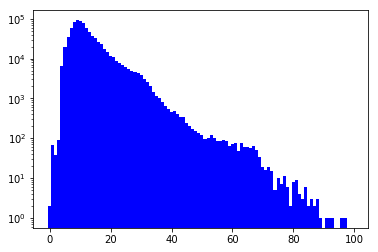

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

y = len_distribution[:100]
N = len(y)
x = range(N)
plt.bar(x, y, 1, color="blue")
plt.yscale('log')

In [10]:
np.sum(len_distribution[100:])

42

In [11]:
max_len = 100

In [12]:
from keras.preprocessing import sequence

empty_word_idx = vocab_size - 1

q1 = sequence.pad_sequences(question1, maxlen=max_len, padding='pre', truncating='post', value=empty_word_idx)
q2 = sequence.pad_sequences(question2, maxlen=max_len, padding='pre', truncating='post', value=empty_word_idx)

Using TensorFlow backend.


In [13]:
from sklearn.model_selection import train_test_split

q1_train, q1_valid, q2_train, q2_valid, labels_train, labels_valid = train_test_split(q1,q2,results, test_size=0.10)

# Load pretrained embeddings

In [14]:
import bcolz
import re
from numpy.random import normal
import _pickle as pickle

def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def load_array(fname):
    return bcolz.open(fname)[:]

In [15]:
glove_vecs, glove_words, glove_wordidx = load_vectors('/data/glove/results/6B.50d')

In [16]:
def create_emb():
    n_fact = glove_vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))
    randomized_tokens = []

    for i in range(1,len(emb)):
        word = words[i]
        if word and word in glove_wordidx:
            src_idx = glove_wordidx[word]
            emb[i] = glove_vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            randomized_tokens.append([i, word])
            emb[i] = normal(scale=0.6, size=(n_fact,))

    emb/=3
    return emb, randomized_tokens

In [17]:
emb, randomized_tokens = create_emb()

In [18]:
len(randomized_tokens)

113

# Convolutional model

In [24]:
vocab_size = len(words)

In [25]:
from keras.models import Model
from keras.layers import Embedding, Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.optimizers import Adam

    

question1_input = Input(shape=(max_len,))
question2_input = Input(shape=(max_len,))


int_embedding = Embedding(vocab_size, 50, input_length=max_len, weights=[emb], trainable=False)
int_dropout = Dropout(0.1)
int_conv = Conv1D(128, 7, padding='same', activation='relu')
int_maxpool = MaxPooling1D()

def int_block(x):
    return int_maxpool(int_conv(int_dropout(int_embedding(x))))

x1 = int_block(question1_input)
x2 = int_block(question2_input)

x = concatenate([x1,x2])
x = Flatten()(x)
x = Dense(200, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(
    inputs=[question1_input, question2_input], 
    outputs=[output], 
)
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(), 
    metrics=['accuracy']
)

In [21]:
model.fit(
    [q1_train, q2_train], 
    labels_train, 
    epochs=2, 
    batch_size=64,
    validation_data=([q1_valid, q2_valid], labels_valid)
)

Train on 363861 samples, validate on 40429 samples
Epoch 1/2
363861/363861 [==============================] - 35s - loss: 0.5217 - acc: 0.7340 - val_loss: 0.4849 - val_acc: 0.7566
Epoch 2/2
363861/363861 [==============================] - 34s - loss: 0.4691 - acc: 0.7683 - val_loss: 0.4592 - val_acc: 0.7737


In [22]:
#model.layers[0].trainable=True
#model.optimizer.lr=1e-4

# Examine model

In [71]:
predictions = model.predict([q1_valid, q2_valid])

In [72]:
predicted_labels = list(map(lambda x: int(round(x)), predictions[:, 0]))

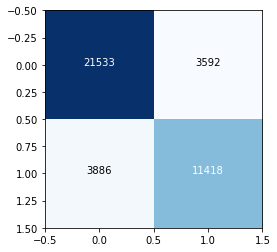

In [73]:
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

cm = confusion_matrix(predicted_labels,labels_valid)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

In [74]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels_valid, predictions, pos_label=1)

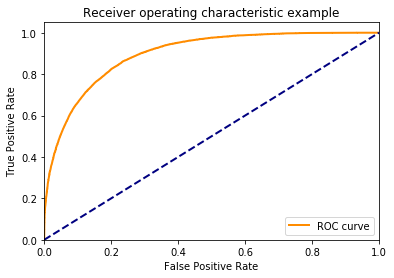

In [75]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Look at some examples

In [76]:
def to_words(tokenized):
    return ' '.join(map(lambda w: words[w], tokenized)).strip()

In [77]:
def print_question_pair(question_pairs):
    for data in question_pairs:
        print(data[2])
        print(data[3])
        print('😄' if int(round(data[0]))== data[1] else '😞', end=' ')
        print('=' if data[1] == 1 else '!', end=' ')
        print('(' + str(data[0]) + ')')
        print('')

In [78]:
validation_results = []
for i in range(len(predicted_labels)):
    validation_results.append(
        [predictions[i, 0], labels_valid[i], to_words(q1_valid[i]), to_words(q2_valid[i])]
    )

### Confident answers

In [79]:
## Confident that it's identical
print_question_pair(
    sorted(validation_results, key=lambda x: x[0])[-5:]
)

why is saltwater taffy candy imported in japan ?
why is saltwater taffy candy imported in south korea ?
😄 = (0.999968)

why is saltwater taffy candy imported in japan ?
why is saltwater taffy candy imported in portugal ?
😄 = (0.999969)

why is saltwater taffy candy imported in greece ?
why is saltwater taffy candy imported in brazil ?
😄 = (0.999969)

why is saltwater taffy candy imported in australia ?
why is saltwater taffy candy imported in switzerland ?
😄 = (0.999974)

why is saltwater taffy candy imported in jamaica ?
why is saltwater taffy candy imported in switzerland ?
😄 = (0.999978)



In [80]:
## Confident that it's different
print_question_pair(
    sorted(validation_results, key=lambda x: x[0])[:5]
)

i can only fall asleep every other night . is my ### ### taking permanent damage ?
can we initiate a java program through a arduino code if not then is there any sms gateway in arduino ?
😄 ! (8.8413e-08)

what is the deepest lake in europe , and how does this lake 's flora and fauna compare to that of lake victoria ?
what is the deepest lake in europe , and how does this lake 's flora and fauna compare to that of lake superior ?
😄 ! (1.43952e-07)

what is the deepest lake in europe , and how does this lake 's flora and fauna compare to that of lake superior ?
what is the deepest lake in europe , and how does this lake 's flora and fauna compare to that of lake ontario ?
😄 ! (1.50966e-07)

which are some of the countries you like or dislike ?
what are the different exams we can attempt by preparing for ies ( ece branch ) ? ( like as i 'm from telangana state i knew only ### ae & ### ) ?
😄 ! (1.57829e-07)

is there is god ?
i use dell adapter with ### ### - ### . what can be the replacem

### Most confident about wrong answer

In [81]:
## Non Identical
print_question_pair(
        sorted(
            filter(lambda x: x[1] == 0,validation_results), 
            key=lambda x: abs(x[1] - x[0])
        )[-5:]
    )

why are the new 500 and 2000 rupees notes not made of plastic ?
what do you think about the new 500 and 2000 rupee notes ?
😞 ! (0.99184)

what are the safety precautions on handling shotguns proposed by the nra in connecticut ?
what are the safety precautions on handling shotguns proposed by the nra in new york ?
😞 ! (0.995571)

why do people ask questions on quora that can easily be answered by google ?
why do people use quora to ask questions when google or wikipedia would be sufficient ?
😞 ! (0.997111)

how will the health sector and insurance sector in india after banning 500 and 1000 rupee notes ?
will the ban on 1000 and 500 rupee notes affect the up and punjab election ?
😞 ! (0.999005)

what 's your new year resolutions for 2017 and what will you do to accomplish your goal ?
what 's your new year resolutions for 2016 and what will you do to accomplish your goal ?
😞 ! (0.999487)



In [82]:
## Identical
print_question_pair(
        sorted(
            filter(lambda x: x[1] == 1,validation_results), 
            key=lambda x: abs(x[1] - x[0])
        )[-5:]
    )

what is reason behind that water ### are on outside of cool water ### ? how that will happen ?
when cool water is ### in a steel glass , the outer side of the steel glass becomes wet and there are water ### in the outer surface . what is the fact behind it ?
😞 = (0.00105404)

how far back in time can a proper english speaker travel and still be able to communicate without using any ### words , or any other language ?
if an ### person was to go back in time in england at what point would he or she no longer be able to understand the english language ?
😞 = (0.000902076)

what does it mean when my husband looks at other women ?
what does it mean when my husband reads face book articles and looks at pictures of online models all the time ?
😞 = (0.000845816)

in how many days paytm ### wallet balance to bank account ?
how much time does it takes to return money from paytm wallet to customer bank account ?
😞 = (0.000826332)

what are the most interesting products and innovations that ### res

### Most unsure

In [83]:
## Non Identical
print_question_pair(
        sorted(
            validation_results,
            key=lambda x: abs(0.5 - x[0])
        )[:10]
    )

how will it be after death ? where does the soul go ?
what happens to the soul after it leaves the body ?
😄 = (0.500021)

what exactly is ### ?
what is an ### ?
😞 = (0.499909)

what 's the genre of this song ?
what genre are these songs ?
😞 ! (0.500099)

why is fox news ### so much ?
why is fox news called fox news ?
😄 ! (0.499865)

can the president pardon himself ?
if the president can pardon , can he pardon himself from crimes ?
😞 = (0.499828)

how do you understand an ### prescription ?
how can you understand your prescription of ### ?
😄 = (0.500178)

what will heaven be like according to christianity ?
how big is heaven according to the bible ?
😞 = (0.499809)

is katrina kaif an actress ?
is katrina kaif underrated actress ? if yes , why ?
😞 ! (0.500224)

what is the difference between virtual reality and mixed reality ?
what is the difference between mixed reality and ### reality ?
😞 = (0.499757)

what is the first thing you notice about other people ?
what do you think other peo

# LSTM Model

In [39]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers import LSTM
from keras.layers import Embedding, Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

    

question1_input = Input(shape=(max_len,))
question2_input = Input(shape=(max_len,))


int_embedding = Embedding(vocab_size, 50, input_length=max_len, weights=[emb], trainable=False)
int_lstm1 = LSTM(100, return_sequences=True)
int_lstm2 = LSTM(100)

x1 = int_embedding(question1_input)
x2 = int_embedding(question2_input)

x1 = int_lstm1(x1)
x2 = int_lstm1(x2)

x1 = int_lstm2(x1)
x2 = int_lstm2(x2)

x = concatenate([x1,x2])
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(
    inputs=[question1_input, question2_input], 
    outputs=[output], 
)
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(), 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(filepath='/data/trained_models/quora/weights.v1.{epoch:02d}-{val_loss:.2f}.hdf5')

In [50]:
model.fit(
    [q1_train, q2_train], 
    labels_train, 
    epochs=10, 
    batch_size=256,
    validation_data=([q1_valid, q2_valid], labels_valid),
    callbacks=[checkpoint]
)

Train on 363861 samples, validate on 40429 samples
Epoch 1/10
363861/363861 [==============================] - 813s - loss: 0.5512 - acc: 0.7086 - val_loss: 0.5224 - val_acc: 0.7291
Epoch 2/10
363861/363861 [==============================] - 810s - loss: 0.5047 - acc: 0.7427 - val_loss: 0.4864 - val_acc: 0.7546
Epoch 3/10
363861/363861 [==============================] - 811s - loss: 0.4772 - acc: 0.7608 - val_loss: 0.4672 - val_acc: 0.7658
Epoch 4/10
363861/363861 [==============================] - 810s - loss: 0.4568 - acc: 0.7744 - val_loss: 0.4563 - val_acc: 0.7738
Epoch 5/10
363861/363861 [==============================] - 810s - loss: 0.4406 - acc: 0.7849 - val_loss: 0.4364 - val_acc: 0.7865
Epoch 6/10
363861/363861 [==============================] - 810s - loss: 0.4260 - acc: 0.7944 - val_loss: 0.4271 - val_acc: 0.7935
Epoch 7/10
363861/363861 [==============================] - 808s - loss: 0.4128 - acc: 0.8021 - val_loss: 0.4204 - val_acc: 0.7982
Epoch 8/10
363861/363861 [======

In [68]:
from keras.models import load_model, save_model

In [41]:
model = load_model('/data/trained_models/quora/weights.v1.06-0.42.hdf5')

In [67]:
model.layers[0].trainable=True
model.optimizer.lr=1e-5

model.fit(
    [q1_train, q2_train], 
    labels_train, 
    epochs=1, 
    batch_size=256,
    validation_data=([q1_valid, q2_valid], labels_valid),
)

Train on 363861 samples, validate on 40429 samples
Epoch 1/1
363861/363861 [==============================] - 817s - loss: 0.3919 - acc: 0.8149 - val_loss: 0.3882 - val_acc: 0.8150


In [70]:
model.save('/data/trained_models/quora/weights.v1.2.hdf5')

AttributeError: 'float' object has no attribute 'eval'

# Gradient Boosted LSTM

In [19]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers import LSTM, Activation
from keras.layers import Embedding, Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import concatenate, add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


class Interpretation:
    def __init__(self):
        self.embedding = Embedding(vocab_size, 50, input_length=max_len, weights=[emb], trainable=False)
        self.lstm1 = LSTM(100, return_sequences=True)
        self.lstm2 = LSTM(100)
        
    def __call__(self,x):
        return self.lstm2(self.lstm1(self.embedding(x)))
    
def compare_network(x1,x2):
    interpretation_block = Interpretation()
    x1 = interpretation_block(x1)
    x2 = interpretation_block(x2)

    x = concatenate([x1,x2])
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    return Dense(1)(x)

question1_input = Input(shape=(max_len,))
question2_input = Input(shape=(max_len,))

network1_output = compare_network(question1_input, question2_input)
network2_output = compare_network(question1_input, question2_input)
network3_output = compare_network(question1_input, question2_input)

output1 = Activation('sigmoid')(network1_output)
output2 = Activation('sigmoid')(add([network1_output, network2_output]))
output3 = Activation('sigmoid')(add([network1_output, network2_output, network3_output]))

model = Model(
    inputs=[question1_input, question2_input], 
    outputs=[output1, output2, output3], 
)
model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(), 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(filepath='/data/trained_models/quora/weights.v3.{epoch:02d}-{val_loss:.2f}.hdf5')

In [20]:
model.fit(
    [q1_train, q2_train], 
    [labels_train, labels_train, labels_train], 
    epochs=10, 
    batch_size=1024,
    validation_data=([q1_valid, q2_valid], [labels_valid,labels_valid,labels_valid]),
    callbacks=[checkpoint]
)

Train on 363861 samples, validate on 40429 samples
Epoch 1/10
363861/363861 [==============================] - 705s - loss: 1.7050 - activation_1_loss: 0.5774 - activation_2_loss: 0.5657 - activation_3_loss: 0.5619 - activation_1_acc: 0.6888 - activation_2_acc: 0.6955 - activation_3_acc: 0.6980 - val_loss: 1.6029 - val_activation_1_loss: 0.5494 - val_activation_2_loss: 0.5311 - val_activation_3_loss: 0.5225 - val_activation_1_acc: 0.7099 - val_activation_2_acc: 0.7224 - val_activation_3_acc: 0.7273
Epoch 2/10
363861/363861 [==============================] - 735s - loss: 1.5632 - activation_1_loss: 0.5373 - activation_2_loss: 0.5186 - activation_3_loss: 0.5073 - activation_1_acc: 0.7199 - activation_2_acc: 0.7301 - activation_3_acc: 0.7378 - val_loss: 1.5163 - val_activation_1_loss: 0.5219 - val_activation_2_loss: 0.5037 - val_activation_3_loss: 0.4907 - val_activation_1_acc: 0.7308 - val_activation_2_acc: 0.7396 - val_activation_3_acc: 0.7501
Epoch 3/10
363861/363861 [=================